In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

2023-11-27 08:11:47.680280: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 08:11:47.723268: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 08:11:47.723296: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 08:11:47.723316: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 08:11:47.728447: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 08:11:47.728788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
import sys
sys.path += ["../../../../particleflow/mlpf/"]
from tfmodel.model_setup import make_model
from tfmodel.utils import parse_config

In [3]:
config, _ = parse_config("../../../../particleflow/parameters/clic.yaml")

In [4]:
model = make_model(config, tf.float32)
model.build((1, None, config["dataset"]["num_input_features"]))


In [5]:
model.summary()

Model: "pf_net_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  multiple                  33        
 on)                                                             
                                                                 
 node_encoding (Sequential)  (1, None, 256)            70912     
                                                                 
 input_encoding_clic (Input  multiple                  0         
 EncodingCLIC)                                                   
                                                                 
 cg_id_0 (CombinedGraphLaye  multiple                  440128    
 r)                                                              
                                                                 
 cg_id_1 (CombinedGraphLaye  multiple                  440128    
 r)                                                   

In [6]:
model.load_weights("weights-96-5.346523.hdf5", skip_mismatch=False, by_name=True)
## These files hosted at https://huggingface.co/jpata/particleflow/tree/clic_clusters_v1.6

In [7]:
## Reading the dataset
ds_builder = tfds.builder("clic_edm_qq_pf", data_dir = '../../../tensorflow_datasets/')
dss = ds_builder.as_data_source("test")



In [8]:
def yield_from_ds():
    for elem in dss:
        yield {"X": elem["X"], "ygen": elem["ygen"], "ycand": elem["ycand"]}
        

In [44]:
output_signature = {k: tf.TensorSpec(shape=(None, v.shape[1])) for (k, v) in dss.dataset_info.features.items()}
tf_dataset = tf.data.Dataset.from_generator(yield_from_ds, output_signature=output_signature).take(100).padded_batch(batch_size=10)
# Taking 100 data points from the TensorFlow datasets in the batch size of 10

In [45]:
data = list(tfds.as_numpy(tf_dataset))


In [46]:
Xs = [d["X"] for d in data]      # 
ys = [d["ygen"] for d in data]

In [47]:
true_pts = []
pred_pts = []

for ibatch in range(len(Xs)):
    ret = model(Xs[ibatch])

    mask_true_particles = ys[ibatch][..., 0]!=0
    
    true_pt = ys[ibatch][mask_true_particles, 2]
    pred_pt = ret["pt"][mask_true_particles][..., 0].numpy()

    true_pts.append(true_pt)
    pred_pts.append(pred_pt)

In [48]:
true_pt = np.concatenate(true_pts)
pred_pt = np.concatenate(pred_pts)

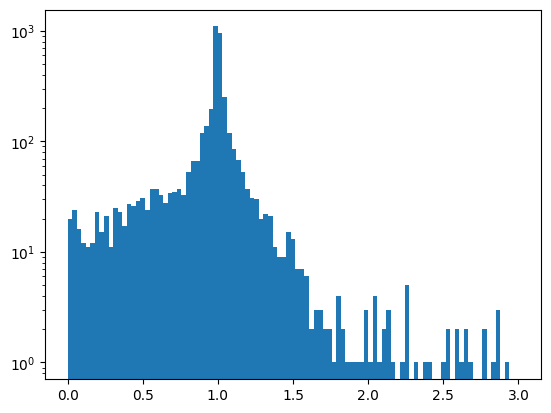

In [49]:
plt.hist(pred_pt/true_pt, bins=np.linspace(0,3,100));
plt.yscale("log")

In [56]:
import ROOT


ModuleNotFoundError: No module named 'ROOT'

## Post-Training Quantization

### Quantize the model

In [50]:
import tensorflow_model_optimization as tfmot

In [51]:
# Convert the new model to a TensorFlow Lite model

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()



2023-11-27 10:33:58.562308: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-27 10:33:58.562335: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-27 10:33:58.563316: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphrzl_pbj
2023-11-27 10:33:58.607348: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-27 10:33:58.607381: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmphrzl_pbj
2023-11-27 10:33:58.758914: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-11-27 10:33:59.371376: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmphrzl_pbj
2023-11-27 10:33:59.740126: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 1176804

In [52]:
# Save the TensorFlow Lite model to a file
with open("quantized_model.tflite", "wb") as f:
    f.write(quantized_tflite_model)

### Quantize the dataset

To quantize the dataset, you can apply quantization to the features and labels before feeding them to the model. You can achieve this by normalizing the values to a quantized range.

In [53]:
# Xs

In [54]:
Xs_quantized = [np.round(X * 127).astype(np.int8) for X in Xs]
Xs_tf = [tf.convert_to_tensor(X_q, dtype=tf.float32) for X_q in Xs_quantized]

ys_quantized = [np.round(y * 127).astype(np.int8) for y in ys]


In [55]:
# Convert quantized features to TensorFlow tensors
Xs_tf = [tf.convert_to_tensor(X_q, dtype=tf.float32) for X_q in Xs_quantized]

# Convert quantized labels to TensorFlow tensors
ys_tf = [tf.convert_to_tensor(y_q, dtype=tf.float32) for y_q in ys_quantized]


After converting the data to TensorFlow tensors, you can perform inference using your quantized model:


In [22]:
# Assuming you have a TensorFlow Lite quantized model (quantized_tflite_model)
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [23]:
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [24]:
# Checking the expected shape of the input tensor
expected_input_shape = input_details[0]['shape']
print("Expected input shape:", expected_input_shape)



Expected input shape: [  1 195  17]


In [25]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [26]:
import time

start_time = time.time()

# Create an interpreter for the quantized model
interpreter_quantized = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter_quantized.allocate_tensors()



In [27]:
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [28]:
# Checking the expected shape of the input tensor
expected_input_shape = input_details[0]['shape']
print("Expected input shape:", expected_input_shape)

Expected input shape: [  1 195  17]


In [29]:
# Run inference
interpreter.invoke()

In [30]:
# Get the output tensor
output_tensor = interpreter.get_tensor(output_details[0]['index'])


In [31]:
import time

start_time = time.time()

# Create an interpreter for the quantized model
interpreter_quantized = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter_quantized.allocate_tensors()


In [32]:
# Measure inference time and process output for the quantized dataset
inference_times_quantized = []


In [33]:
for X_q in Xs_tf:
    # Print the shape of X_q before reshaping
    print("Shape of X_q before reshaping:", X_q.shape)
    
    

Shape of X_q before reshaping: (100, 195, 17)
Shape of X_q before reshaping: (100, 159, 17)
Shape of X_q before reshaping: (100, 173, 17)
Shape of X_q before reshaping: (100, 144, 17)
Shape of X_q before reshaping: (100, 192, 17)
Shape of X_q before reshaping: (100, 189, 17)
Shape of X_q before reshaping: (100, 193, 17)
Shape of X_q before reshaping: (100, 183, 17)
Shape of X_q before reshaping: (100, 186, 17)
Shape of X_q before reshaping: (100, 162, 17)


In [43]:
# Initialize lists to store true and predicted values
true_pts_quantized = []
pred_pts_quantized = []

# Perform inference on the quantized dataset
for X_q in Xs_tf:
    # Assuming X_q is a NumPy array
    target_shape = (1, 195, 17)

    # Determine the length of the second dimension in X_q
    current_length = X_q.shape[1]

    # Pad or truncate X_q to match the target length
    if current_length < target_shape[1]:
        # Pad with zeros
        X_q_padded = np.pad(X_q, ((0, 0), (0, target_shape[1] - current_length), (0, 0)), mode='constant')
    elif current_length > target_shape[1]:
        # Truncate
        X_q_padded = X_q[:, :target_shape[1], :]
    else:
        # No need to change the shape
        X_q_padded = X_q

    # Print the shapes for debugging
    print(f"Shape of X_q_padded: {X_q_padded.shape}")

    # Reshape to match the expected shape
    X_q_reshaped = np.resize(X_q_padded, target_shape)

    # Print the shape for debugging
    print(f"Shape of X_q_reshaped: {X_q_reshaped.shape}")

    # Set input tensor
    interpreter_quantized.set_tensor(input_details[0]['index'], X_q_reshaped)

    # Run inference
    start_time = time.time()
    interpreter_quantized.invoke()
    end_time = time.time()
    inference_times_quantized.append(end_time - start_time)

    # Get output tensor
    output_tensor_quantized = interpreter_quantized.get_tensor(output_details[0]['index'])

    # Process the output as needed
    # Assuming a classification task with softmax output
    predicted_probabilities_quantized = output_tensor_quantized[0]

    # Get the confidence score for the true class
    confidence_score_quantized = predicted_probabilities_quantized[0, mask_true_particles[0, :195], :]

    # Get the predicted class (index with the highest probability)
    predicted_class_quantized = np.argmax(predicted_probabilities_quantized, axis=1)
    
    # Extract the first row for boolean indexing
    mask_true_particles_row = mask_true_particles[0, :10]
    
    # Append true and predicted pt values
    true_pt_quantized = ys[ibatch][mask_true_particles_row, 2]
    pred_pt_quantized = confidence_score_quantized  # Adjust based on your output structure
    true_pts_quantized.append(true_pt_quantized)
    pred_pts_quantized.append(pred_pt_quantized)
    
# After the loop, concatenate true and predicted pt values
true_pt_quantized = np.concatenate(true_pts_quantized)
pred_pt_quantized = np.concatenate(pred_pts_quantized)

# Print the final shapes for debugging
print(f"Final shape of true_pt_quantized: {true_pt_quantized.shape}")
print(f"Final shape of pred_pt_quantized: {pred_pt_quantized.shape}")

# Plot the histogram
plt.hist(pred_pt_quantized[:80] / true_pt_quantized[:, 0], bins=np.linspace(0, 3, 100))
plt.title("After INT8 Quantization")
plt.yscale("log")
plt.show()


Shape of X_q_padded: (100, 195, 17)
Shape of X_q_reshaped: (1, 195, 17)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

with another method

/tmp/ipykernel_42840/225353060.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.hist(pred_pt_quantized / true_pt_quantized_repeated, bins=np.linspace(0, 3, 100))
/tmp/ipykernel_42840/225353060.py:6: RuntimeWarning: invalid value encountered in divide
  plt.hist(pred_pt_quantized / true_pt_quantized_repeated, bins=np.linspace(0, 3, 100))


(array([[ 19.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         113.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 19.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         106.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0

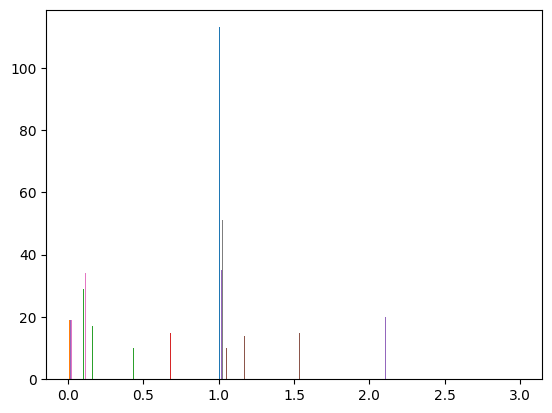

In [37]:
# Repeat the true_pt_quantized to match or exceed the length of pred_pt_quantized
repetition_factor = (pred_pt_quantized.shape[0] + true_pt_quantized.shape[0] - 1) // true_pt_quantized.shape[0]
true_pt_quantized_repeated = np.repeat(true_pt_quantized, repetition_factor, axis=0)[:pred_pt_quantized.shape[0]]

# Perform element-wise division
plt.hist(pred_pt_quantized / true_pt_quantized_repeated, bins=np.linspace(0, 3, 100))


In [42]:
total_inference_time_quantized = sum(inference_times_quantized)
print(f"Total Inference Time (Quantized): {total_inference_time_quantized} seconds")


Total Inference Time (Quantized): 1.5244393348693848 seconds


Above one is the fixed point quantization. Dynamic Range Quantization aims to quantize weights and activations based on their dynamic ranges during inference. TensorFlow Lite supports dynamic range quantization, and you can apply it to your model.

## Dynamic Range Quantization for the model

In [46]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.lite.python import lite_constants

In [47]:
# Convert the model to a TensorFlow Lite model with dynamic range quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
dynamic_range_tflite_model = converter.convert()

2023-11-23 15:51:32.931476: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-23 15:51:32.931499: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-23 15:51:32.932148: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpo7dg31qn
2023-11-23 15:51:32.978463: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-23 15:51:32.978495: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpo7dg31qn
2023-11-23 15:51:33.128516: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-11-23 15:51:33.743916: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpo7dg31qn
2023-11-23 15:51:34.095803: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 1163655

In [48]:
# Save the dynamically quantized model
with open('dynamic_range_quantized_model.tflite', 'wb') as f:
    f.write(dynamic_range_tflite_model)

In [49]:
# Assuming you have a TensorFlow Lite dynamic range quantized model (dynamic_range_tflite_model)
interpreter = tf.lite.Interpreter(model_content=dynamic_range_tflite_model)
interpreter.allocate_tensors()


In [50]:
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [52]:
# Lists to store true and predicted pt values
true_pts_quantized = []
pred_pts_quantized = []

# Measure inference time and process output for the quantized dataset
inference_times_quantized = []

# Run inference
interpreter.invoke()


In [53]:
# Get the output tensor
output_tensor = interpreter.get_tensor(output_details[0]['index'])

import time

start_time = time.time()


In [54]:

# Create an interpreter for the dynamic range quantized model
interpreter_dynamic_range = tf.lite.Interpreter(model_content=dynamic_range_tflite_model)
interpreter_dynamic_range.allocate_tensors()


In [55]:
# Perform inference on the quantized dataset
for X_q in Xs_tf:
    # Assuming X_q is a NumPy array
    target_shape = (1, 111, 17)

    # Determine the length of the second dimension in X_q
    current_length = X_q.shape[1]

    # Pad or truncate X_q to match the target length
    if current_length < target_shape[1]:
        # Pad with zeros
        X_q_padded = np.pad(X_q, ((0, 0), (0, target_shape[1] - current_length), (0, 0)), mode='constant')
    elif current_length > target_shape[1]:
        # Truncate
        X_q_padded = X_q[:, :target_shape[1], :]
    else:
        # No need to change the shape
        X_q_padded = X_q

    # Print the shapes for debugging
    print(f"Shape of X_q_padded: {X_q_padded.shape}")
    
    
    # Reshape to match the expected shape
    X_q_reshaped = np.resize(X_q_padded, target_shape)

    # Print the shape for debugging
    print(f"Shape of X_q_reshaped: {X_q_reshaped.shape}")

    # Set input tensor
    interpreter_dynamic_range.set_tensor(input_details[0]['index'], X_q_reshaped)

    # Run inference
    start_time = time.time()
    interpreter_dynamic_range.invoke()
    end_time = time.time()
    inference_times_quantized.append(end_time - start_time)

    
    # Get output tensor
    output_tensor_dynamic_range = interpreter_dynamic_range.get_tensor(output_details[0]['index'])

    # Process the output as needed
    # Assuming a classification task with softmax output
    predicted_probabilities_dynamic_range = output_tensor_dynamic_range[0]

    # Get the confidence score for the true class
    confidence_score_dynamic_range = predicted_probabilities_dynamic_range[mask_true_particles[0, :111]]

    # Get the predicted class (index with the highest probability)
    predicted_class_dynamic_range = np.argmax(predicted_probabilities_dynamic_range, axis=1)

    # Extract the first row for boolean indexing
    mask_true_particles_row = mask_true_particles[0, :10]
    
    # Append true and predicted pt values
    true_pt_dynamic_range = ys[ibatch][mask_true_particles_row, 2]
    pred_pt_dynamic_range = confidence_score_dynamic_range  # Adjust based on your output structure
    true_pts_quantized.append(true_pt_dynamic_range)
    pred_pts_quantized.append(pred_pt_dynamic_range)




Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)


Final shape of true_pt_dynamic_range: (80, 8)
Final shape of pred_pt_dynamic_range: (270, 1)


/tmp/ipykernel_42840/334781023.py:10: RuntimeWarning: divide by zero encountered in divide
  plt.hist(pred_pt_dynamic_range[:80] / true_pt_dynamic_range[:, 0], bins=np.linspace(0, 3, 100))
/tmp/ipykernel_42840/334781023.py:10: RuntimeWarning: invalid value encountered in divide
  plt.hist(pred_pt_dynamic_range[:80] / true_pt_dynamic_range[:, 0], bins=np.linspace(0, 3, 100))


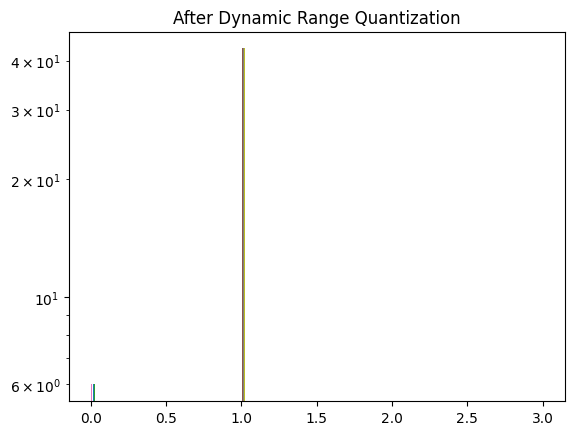

In [56]:
# After the loop, concatenate true and predicted pt values
true_pt_dynamic_range = np.concatenate(true_pts_quantized)
pred_pt_dynamic_range = np.concatenate(pred_pts_quantized)

# Print the final shapes for debugging
print(f"Final shape of true_pt_dynamic_range: {true_pt_dynamic_range.shape}")
print(f"Final shape of pred_pt_dynamic_range: {pred_pt_dynamic_range.shape}")

# Plot the histogram
plt.hist(pred_pt_dynamic_range[:80] / true_pt_dynamic_range[:, 0], bins=np.linspace(0, 3, 100))
plt.title("After Dynamic Range Quantization")
plt.yscale("log")
plt.show()

/tmp/ipykernel_42840/269767976.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.hist(pred_pt_dynamic_range / true_pt_quantized_repeated, bins=np.linspace(0, 3, 100))
/tmp/ipykernel_42840/269767976.py:6: RuntimeWarning: invalid value encountered in divide
  plt.hist(pred_pt_dynamic_range / true_pt_quantized_repeated, bins=np.linspace(0, 3, 100))


(array([[ 19.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         113.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 19.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         106.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0

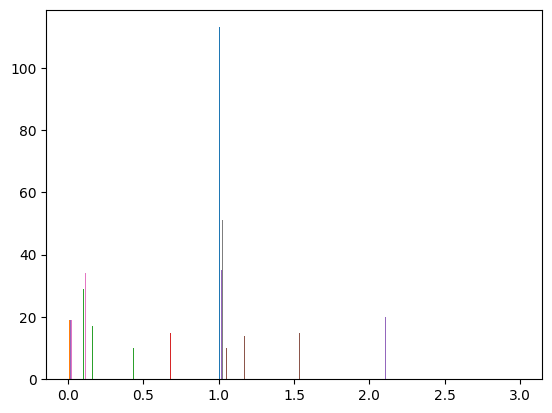

In [57]:
# Repeat the true_pt_quantized to match or exceed the length of pred_pt_quantized
repetition_factor = (pred_pt_dynamic_range.shape[0] + true_pt_dynamic_range.shape[0] - 1) // true_pt_dynamic_range.shape[0]
true_pt_quantized_repeated = np.repeat(true_pt_dynamic_range, repetition_factor, axis=0)[:pred_pt_dynamic_range.shape[0]]

# Perform element-wise division
plt.hist(pred_pt_dynamic_range / true_pt_quantized_repeated, bins=np.linspace(0, 3, 100))


## Full-integer Quantization